<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> DM-46495 Filter unassociated diaSources before creating new diaObjects </b><br>
Notebook comparing main with the DM-46495 branch of ap_association<br> <br>

Contact author: Ian Sullivan <br>
Last verified to run: 8 April 2025 <br>
LSST Science Pipelines version: <code>w_2025_11</code> (with DM-46495 changes) and <code>w_2025_11</code> <br>
Additional notes: run at the USDF with the diffim validation dataset from ComCam <br>

## Run details

Run with the prototype clustering with strict visit ordering on DM-46294 of ctrl_bps and ctrl_bps_htcondor.

Visits:
2024120600098,2024112000208,2024112800140,2024111100094,2024111900082,2024111600297
All nine CCDs


## 1. Main package imports

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import gc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from IPython.display import Image
from lsst.afw.image import MultibandExposure
from lsst.analysis.ap import apdb, nb_utils
from lsst.analysis.ap import plotImageSubtractionCutouts as plotISC
from lsst.daf.butler import Butler
from lsst.ip.diffim import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from sqlalchemy import select, func

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
from matplotlib.lines import Line2D

## 2. Configuring data access

In [2]:
!pwd

/home/s/sullii/notebooks/ap_pipe-notebooks/notebooks


In [3]:
repo = '/repo/main'
collections_main = 'u/sullii/DM-46495'
collections_test = 'u/sullii/DM-46495-useFilter'
instrument = 'LSSTComCam'
skymap = 'lsst_cells_v1'

butler_main = Butler(repo, collections=collections_main)
butler_test = Butler(repo, collections=collections_test)

dbType = 'sqlite'
dbName_main = '/home/s/sullii/project/tickets/DM-46495/APDB/main.sqlite3'
dbName_test = '/home/s/sullii/project/tickets/DM-46495/APDB/useFilter.sqlite3'

reader_main = apdb.ApdbSqliteQuery(dbName_main, instrument=instrument)
reader_test = apdb.ApdbSqliteQuery(dbName_test, instrument=instrument)

In [4]:
collections_test1 = 'u/sullii/DM-46495-SN-Filter'
collections_test2 = 'u/sullii/DM-46495-reliability-Filter'

butler_test1 = Butler(repo, collections=collections_test1)
butler_test2 = Butler(repo, collections=collections_test2)

dbName_test1 = '/home/s/sullii/project/tickets/DM-46495/APDB/SN-Filter.sqlite3'
dbName_test2 = '/home/s/sullii/project/tickets/DM-46495/APDB/reliability-Filter.sqlite3'

reader_test1 = apdb.ApdbSqliteQuery(dbName_test1, instrument=instrument)
reader_test2 = apdb.ApdbSqliteQuery(dbName_test2, instrument=instrument)

In [5]:
collections_test3 = 'u/sullii/DM-46495-SN-Filter'
collections_test4 = 'u/sullii/DM-46495-reliability-Filter'

butler_test3 = Butler(repo, collections=collections_test3)
butler_test4 = Butler(repo, collections=collections_test4)

dbName_test3 = '/home/s/sullii/project/tickets/DM-46495/APDB/badFlags-Filter.sqlite3'
dbName_test4 = '/home/s/sullii/project/tickets/DM-46495/APDB/combo-Filter.sqlite3'

reader_test3 = apdb.ApdbSqliteQuery(dbName_test3, instrument=instrument)
reader_test4 = apdb.ApdbSqliteQuery(dbName_test4, instrument=instrument)

In [6]:
len(reader_main._tables), len(reader_test._tables)

(6, 6)

## 3. Load additional test runs:

In [12]:
main_run = {
    'repo': repo,
    'collections': collections_main,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_main,
    'dbType': dbType,
    'dbName': dbName_main,
    'reader': reader_main
}

test_run = {
    'repo': repo,
    'collections': collections_test,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_test,
    'dbType': dbType,
    'dbName': dbName_test,
    'reader': reader_test
}

In [13]:
test1_run = {
    'repo': repo,
    'collections': collections_test1,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_test1,
    'dbType': dbType,
    'dbName': dbName_test1,
    'reader': reader_test1
}
test2_run = {
    'repo': repo,
    'collections': collections_test2,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_test2,
    'dbType': dbType,
    'dbName': dbName_test2,
    'reader': reader_test2
}

In [14]:
test3_run = {
    'repo': repo,
    'collections': collections_test3,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_test3,
    'dbType': dbType,
    'dbName': dbName_test3,
    'reader': reader_test3
}
test4_run = {
    'repo': repo,
    'collections': collections_test4,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_test4,
    'dbType': dbType,
    'dbName': dbName_test4,
    'reader': reader_test4
}

In [15]:
main_run['run_name'] = 'Without filtering'
test_run['run_name'] = 'With SN<2, reliability<0.1, and SN<8 + reliability<0.25 filter'

In [16]:
test1_run['run_name'] = 'With SN<2 filter'
test2_run['run_name'] = 'With reliability<0.1 filter'

In [17]:
test3_run['run_name'] = 'With bad flag filter'
test4_run['run_name'] = 'With reliability<0.05, SN<0.5, SN<2 and reliability<0.1 and bad flag filter'

In [18]:
main_run['robjTable'] = main_run['reader'].load_objects()
main_run['rsrcTable'] = main_run['reader'].load_sources()

test_run['robjTable'] = test_run['reader'].load_objects()
test_run['rsrcTable'] = test_run['reader'].load_sources()

In [19]:
test1_run['robjTable'] = test1_run['reader'].load_objects()
test1_run['rsrcTable'] = test1_run['reader'].load_sources()

test2_run['robjTable'] = test2_run['reader'].load_objects()
test2_run['rsrcTable'] = test2_run['reader'].load_sources()

In [20]:
test3_run['robjTable'] = test3_run['reader'].load_objects()
test3_run['rsrcTable'] = test3_run['reader'].load_sources()

test4_run['robjTable'] = test4_run['reader'].load_objects()
test4_run['rsrcTable'] = test4_run['reader'].load_sources()

## 4. Investigate possible bad flags from the `main` run

In [21]:
for c in main_run['rsrcTable'].columns:
    try:
        num = len(main_run['rsrcTable'].query(f'{c} == True'))
        if num > 0:
            print(f"{c}: {num}")
    except Exception as e:
        pass

detector: 403
centroid_flag: 654
apFlux_flag: 657
apFlux_flag_apertureTruncated: 3
psfFlux_flag: 668
psfFlux_flag_edge: 43
forced_PsfFlux_flag: 668
forced_PsfFlux_flag_edge: 43
shape_flag: 1682
extendedness: 36
isDipole: 1187
dipoleFitAttempted: 1188
pixelFlags_cr: 30
pixelFlags_crCenter: 7
pixelFlags_nodata: 134
pixelFlags_nodataCenter: 5
pixelFlags_interpolated: 256
pixelFlags_interpolatedCenter: 105
pixelFlags_saturated: 228
pixelFlags_saturatedCenter: 98
pixelFlags_suspect: 225
pixelFlags_suspectCenter: 82
pixelFlags_streak: 69
pixelFlags_streakCenter: 46


### From the above list, suggest excluding sources with the following flags:

In [22]:
badFlags = [
    "pixelFlags_crCenter",
    "pixelFlags_nodataCenter",
    "pixelFlags_interpolatedCenter",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspectCenter",
    "pixelFlags_streakCenter",
]

## 5. Set up useful lists of visits and detectors in the datasets:

In [23]:
registry_main = butler_main.registry
registry_test = butler_test.registry

datarefs_main = list(registry_main.queryDatasets('initial_pvi'))
datarefs_test = list(registry_test.queryDatasets('initial_pvi'))

In [24]:
visits = [2024120600098, 2024112000208, 2024112800140, 2024111100094, 2024111900082, 2024111600297]
detectors = [0,1,2,3,4,5,6,7,8]

In [25]:
from itertools import product

visits = [2024120600098, 2024112000208, 2024112800140, 2024111100094, 2024111900082, 2024111600297]
detectors = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Create all combinations of visits and detectors
combinations = list(product(visits, detectors))

# Create a DataFrame from the combinations
visitsAndDetectors = pd.DataFrame(combinations, columns=['visits', 'detectors'])

# Sort the DataFrame by visits and detectors
visitsAndDetectors = visitsAndDetectors.sort_values(by=['visits', 'detectors'])

# Reset the index
visitsAndDetectors = visitsAndDetectors.reset_index(drop=True)

print(visitsAndDetectors)

           visits  detectors
0   2024111100094          0
1   2024111100094          1
2   2024111100094          2
3   2024111100094          3
4   2024111100094          4
5   2024111100094          5
6   2024111100094          6
7   2024111100094          7
8   2024111100094          8
9   2024111600297          0
10  2024111600297          1
11  2024111600297          2
12  2024111600297          3
13  2024111600297          4
14  2024111600297          5
15  2024111600297          6
16  2024111600297          7
17  2024111600297          8
18  2024111900082          0
19  2024111900082          1
20  2024111900082          2
21  2024111900082          3
22  2024111900082          4
23  2024111900082          5
24  2024111900082          6
25  2024111900082          7
26  2024111900082          8
27  2024112000208          0
28  2024112000208          1
29  2024112000208          2
30  2024112000208          3
31  2024112000208          4
32  2024112000208          5
33  2024112000

## 6. APBD Source Comparison

#### Comparing main with filtering

In [26]:
print(f"Set 1: {test_run['run_name']}, set 2: {main_run['run_name']}")
unique_test, unique_main, matched = nb_utils.compare_sources(repo, repo, reader_test, reader_main)

Set 1: With SN<2, reliability<0.1, and SN<8 + reliability<0.25 filter, set 2: Without filtering
329 matched sources; 0 unique to set 1; 2899 unique to set 2.


In [28]:
print(f"Set 1: {test1_run['run_name']}, set 2: {main_run['run_name']}")
unique_test1, unique_main1, matched1 = nb_utils.compare_sources(repo, repo, reader_test1, reader_main)

Set 1: With SN<2 filter, set 2: Without filtering
2021 matched sources; 0 unique to set 1; 1248 unique to set 2.


In [29]:
print(f"Set 1: {test2_run['run_name']}, set 2: {main_run['run_name']}")
unique_test2, unique_main2, matched2 = nb_utils.compare_sources(repo, repo, reader_test2, reader_main)

Set 1: With reliability<0.1 filter, set 2: Without filtering
569 matched sources; 0 unique to set 1; 2659 unique to set 2.


In [30]:
print(f"Set 1: {test3_run['run_name']}, set 2: {main_run['run_name']}")
unique_test3, unique_main3, matched3 = nb_utils.compare_sources(repo, repo, reader_test3, reader_main)

Set 1: With bad flag filter, set 2: Without filtering
3231 matched sources; 0 unique to set 1; 38 unique to set 2.


In [31]:
print(f"Set 1: {test4_run['run_name']}, set 2: {main_run['run_name']}")
unique_test4, unique_main4, matched4 = nb_utils.compare_sources(repo, repo, reader_test4, reader_main)

Set 1: With reliability<0.05, SN<0.5, SN<2 and reliability<0.1 and bad flag filter, set 2: Without filtering
610 matched sources; 0 unique to set 1; 2659 unique to set 2.


## 7. Visualizing APDB Source Comparison

In [32]:
sns.color_palette("Spectral", 20)

[(0.7211072664359862, 0.11649365628604381, 0.28281430219146486),
 (0.8226066897347175, 0.22906574394463664, 0.30680507497116494),
 (0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.942560553633218, 0.4057670126874279, 0.2682814302191465),
 (0.9693194925028835, 0.5174163783160323, 0.30426758938869664),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9953094963475586, 0.8399846212995001, 0.5128027681660899),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9990003844675125, 0.9690119184928874, 0.697039600153787),
 (0.9750096116878124, 0.9900038446751249, 0.7100346020761246),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.8565936178392929, 0.942329873125721, 0.6053056516724337),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.4955017301038063, 0.7981545559400232, 0.6456747404844291),
 (0.3760092272202999, 0.7340253748558246, 0.6581314878892733),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197),
 (0.20622837370242214, 0.5201845444059977, 0.7349480968858132),
 (0.2874279123414072, 0.4149942329873126, 0.6851211072664359)]

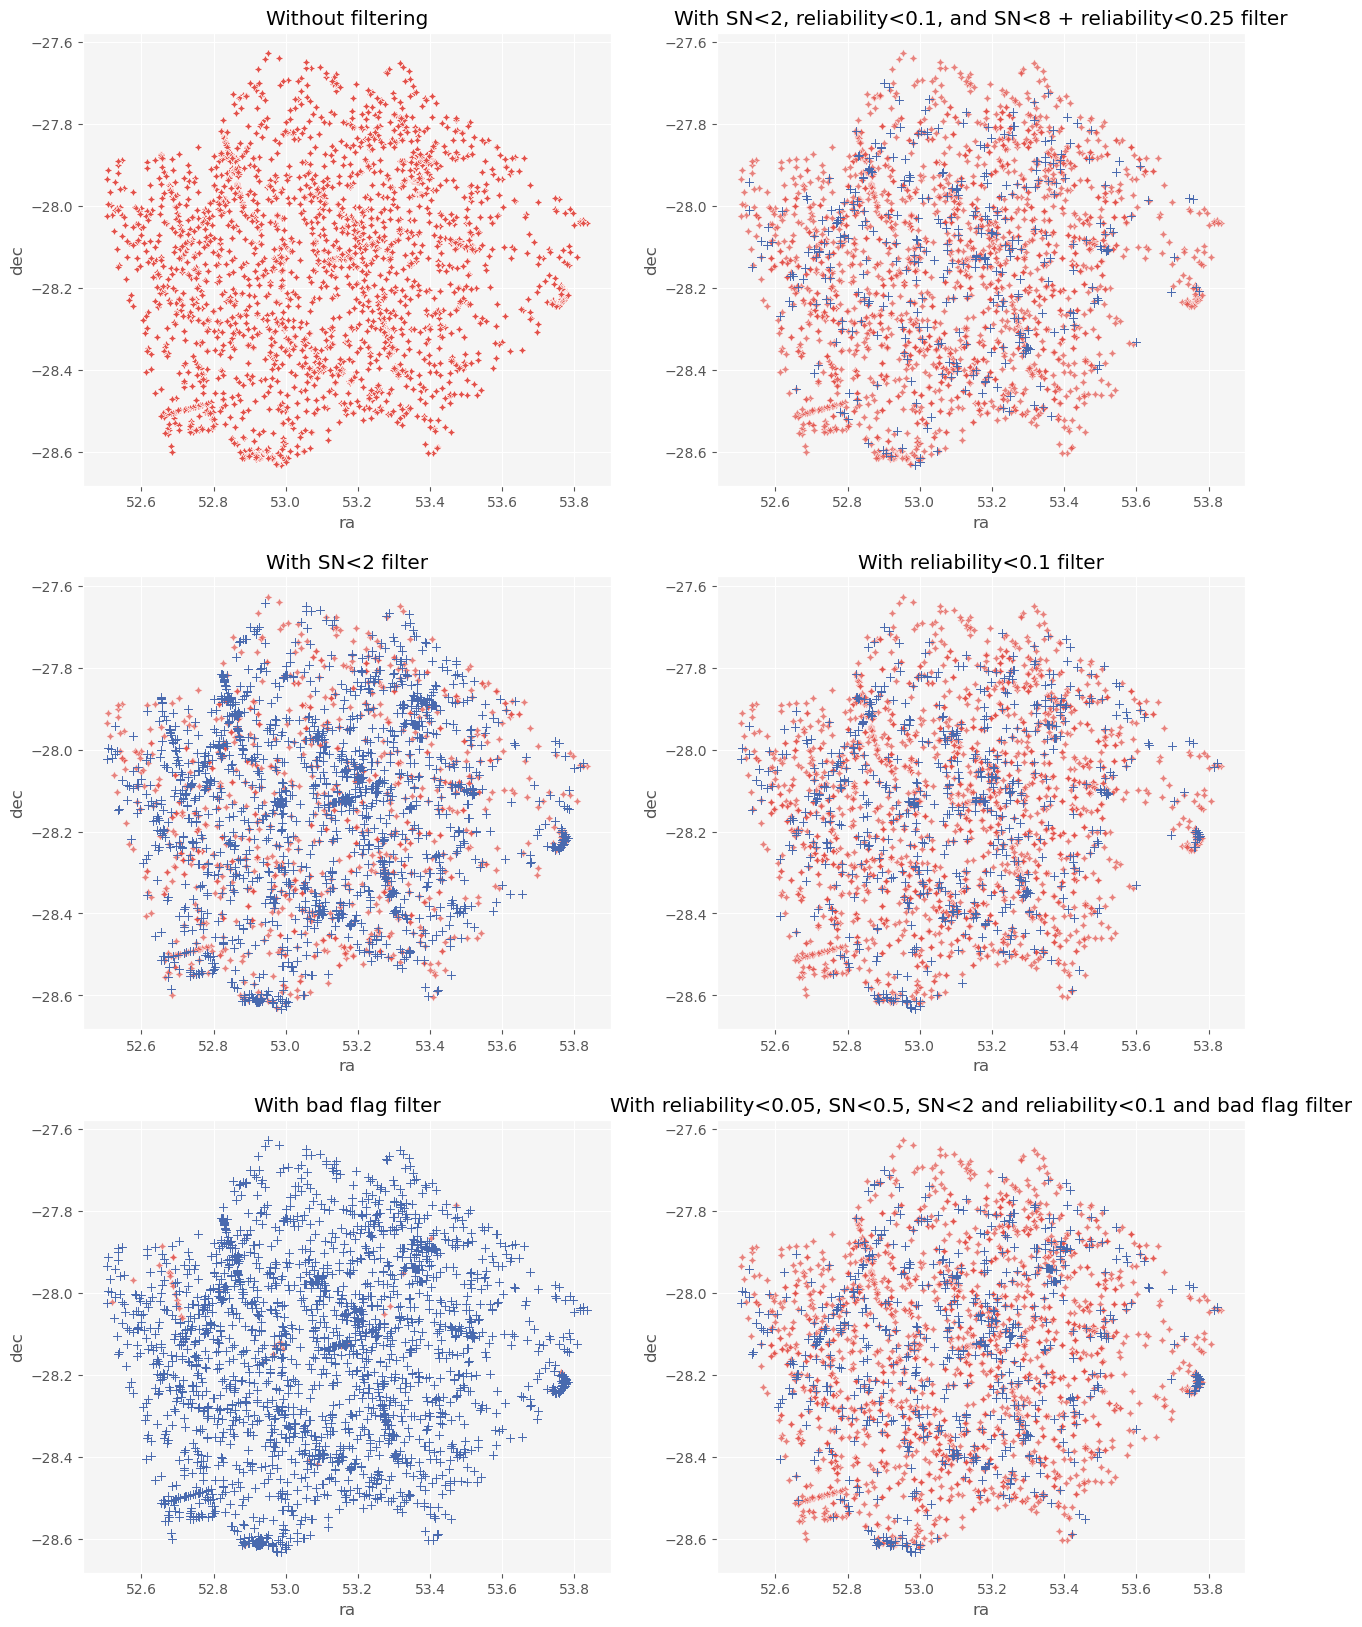

In [33]:
# Full catalogs from Sources With and Without filtering
f, axes = plt.subplots(3, 2, figsize=(15,20))
main_color = 2
test_color = 19
main_marker = (4,1,0)
test_marker = (4,2,0)
main_alpha = 0.7
test_alpha = 1

sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=1, ax=axes[0, 0]).set(title=main_run['run_name']);

sns.scatterplot(data=unique_main, x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=main_alpha, ax=axes[0, 1]);
sns.scatterplot(data=test_run['rsrcTable'], x='ra', y='dec', marker=test_marker, color=sns.color_palette("Spectral", 20)[test_color], alpha=test_alpha, ax=axes[0, 1]).set(title=test_run['run_name']);

sns.scatterplot(data=unique_main1, x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=main_alpha, ax=axes[1, 0]);
sns.scatterplot(data=test1_run['rsrcTable'], x='ra', y='dec', marker=test_marker, color=sns.color_palette("Spectral", 20)[test_color], alpha=test_alpha, ax=axes[1, 0]).set(title=test1_run['run_name']);

sns.scatterplot(data=unique_main2, x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=main_alpha, ax=axes[1, 1]);
sns.scatterplot(data=test2_run['rsrcTable'], x='ra', y='dec', marker=test_marker, color=sns.color_palette("Spectral", 20)[test_color], alpha=test_alpha, ax=axes[1, 1]).set(title=test2_run['run_name']);

sns.scatterplot(data=unique_main3, x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=main_alpha, ax=axes[2, 0]);
sns.scatterplot(data=test3_run['rsrcTable'], x='ra', y='dec', marker=test_marker, color=sns.color_palette("Spectral", 20)[test_color], alpha=test_alpha, ax=axes[2, 0]).set(title=test3_run['run_name']);

sns.scatterplot(data=unique_main4, x='ra', y='dec', marker=main_marker, color=sns.color_palette("Spectral", 20)[main_color], alpha=main_alpha, ax=axes[2, 1]);
sns.scatterplot(data=test4_run['rsrcTable'], x='ra', y='dec', marker=test_marker, color=sns.color_palette("Spectral", 20)[test_color], alpha=test_alpha, ax=axes[2, 1]).set(title=test4_run['run_name']);


In the above plots, diaSources that would be removed are in red and unaffected diaSources are in blue.
The SN<2 cut does very little to remove clumps of sources that are likely junk, such as the linear features or the c-shaped cluster on the middle right.
The reliability < 0.1 cut does a pretty good job of removing the clusters of sources.

In [45]:
print(main_run['run_name'], np.sum(main_run['rsrcTable']['detector'].value_counts()))
print(test_run['run_name'], np.sum(test_run['rsrcTable']['detector'].value_counts()))
print(test1_run['run_name'], np.sum(test1_run['rsrcTable']['detector'].value_counts()))
print(test2_run['run_name'], np.sum(test2_run['rsrcTable']['detector'].value_counts()))
print(test3_run['run_name'], np.sum(test3_run['rsrcTable']['detector'].value_counts()))
print(test4_run['run_name'], np.sum(test4_run['rsrcTable']['detector'].value_counts()))

Without filtering 3525
With SN<2, reliability<0.1, and SN<8 + reliability<0.25 filter 382
With SN<2 filter 2246
With reliability<0.1 filter 665
With bad flag filter 3392
With reliability<0.05, SN<0.5, SN<2 and reliability<0.1 and bad flag filter 688


Number of dia_sources passing each of the cuts

## 8. Source distribution Comparison

#### Compare source distributions in detector coordinates

[Text(0.5, 1.0, 'With reliability<0.05, SN<0.5, SN<2 and reliability<0.1 and bad flag filter')]

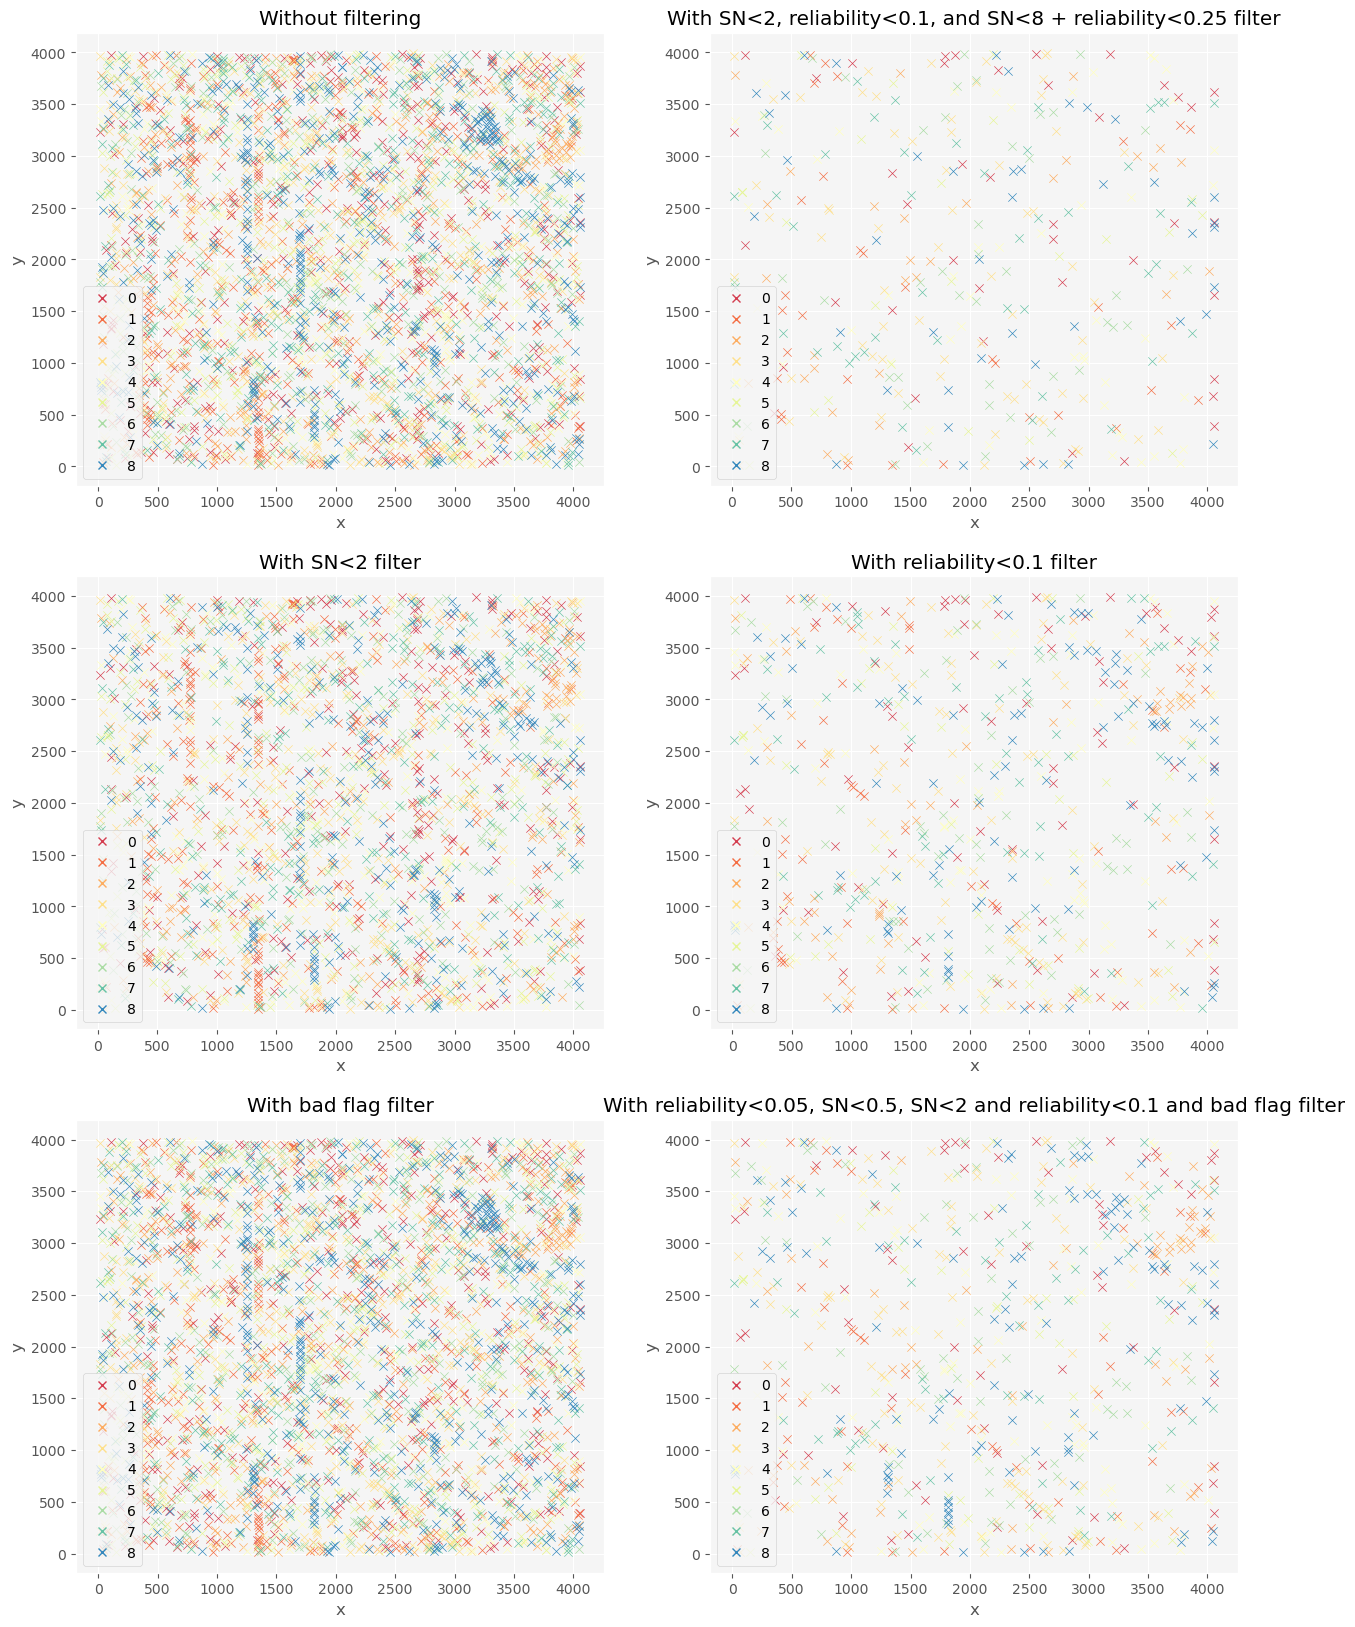

In [35]:
f, axes = plt.subplots(3, 2, figsize=(15,20))
detectors = list(range(9))

# Set custom legend with all detectors
palette = sns.color_palette("Spectral", 9)
legend_elements = [Line2D([0], [0], marker='x', color=palette[i], linestyle='None', 
                         label=f'{i}') for i in range(9)]
for d in detectors:
    filtered_df = main_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[0, 0], color=palette[d])
    filtered_df = test_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[0, 1], color=palette[d])
    
    filtered_df = test1_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[1, 0], color=palette[d])
    
    filtered_df = test2_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[1, 1], color=palette[d])

    filtered_df = test3_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[2, 0], color=palette[d])
    
    filtered_df = test4_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='x', y='y', 
                         marker='x', alpha=1.0, ax=axes[2, 1], color=palette[d])

axes[0, 0].legend(handles=legend_elements)
axes[0, 0].set(title=main_run['run_name'])                        
axes[0, 1].legend(handles=legend_elements)
axes[0, 1].set(title=test_run['run_name'])                     
axes[1, 0].legend(handles=legend_elements)
axes[1, 0].set(title=test1_run['run_name'])                     
axes[1, 1].legend(handles=legend_elements)
axes[1, 1].set(title=test2_run['run_name'])                 
axes[2, 0].legend(handles=legend_elements)
axes[2, 0].set(title=test3_run['run_name'])                     
axes[2, 1].legend(handles=legend_elements)
axes[2, 1].set(title=test4_run['run_name'])

Multiple columns of sources from the same detector are apparent, and the bad flag filter and signal-to-noise filters do not appear to eliminate many of them.
The reliability cuts on the right appear to reduce most of these columns of sources, but at the expense of eliminating the majority of sources.
Given our recent experience classifying cutouts, it is possible that we have that many noise and "junk" sources, so this might be desirable behavior.
We need to check completeness with fake source injection to be sure.

#### Compare source distributions in celestial coordinates

[Text(0.5, 1.0, 'With reliability<0.05, SN<0.5, SN<2 and reliability<0.1 and bad flag filter')]

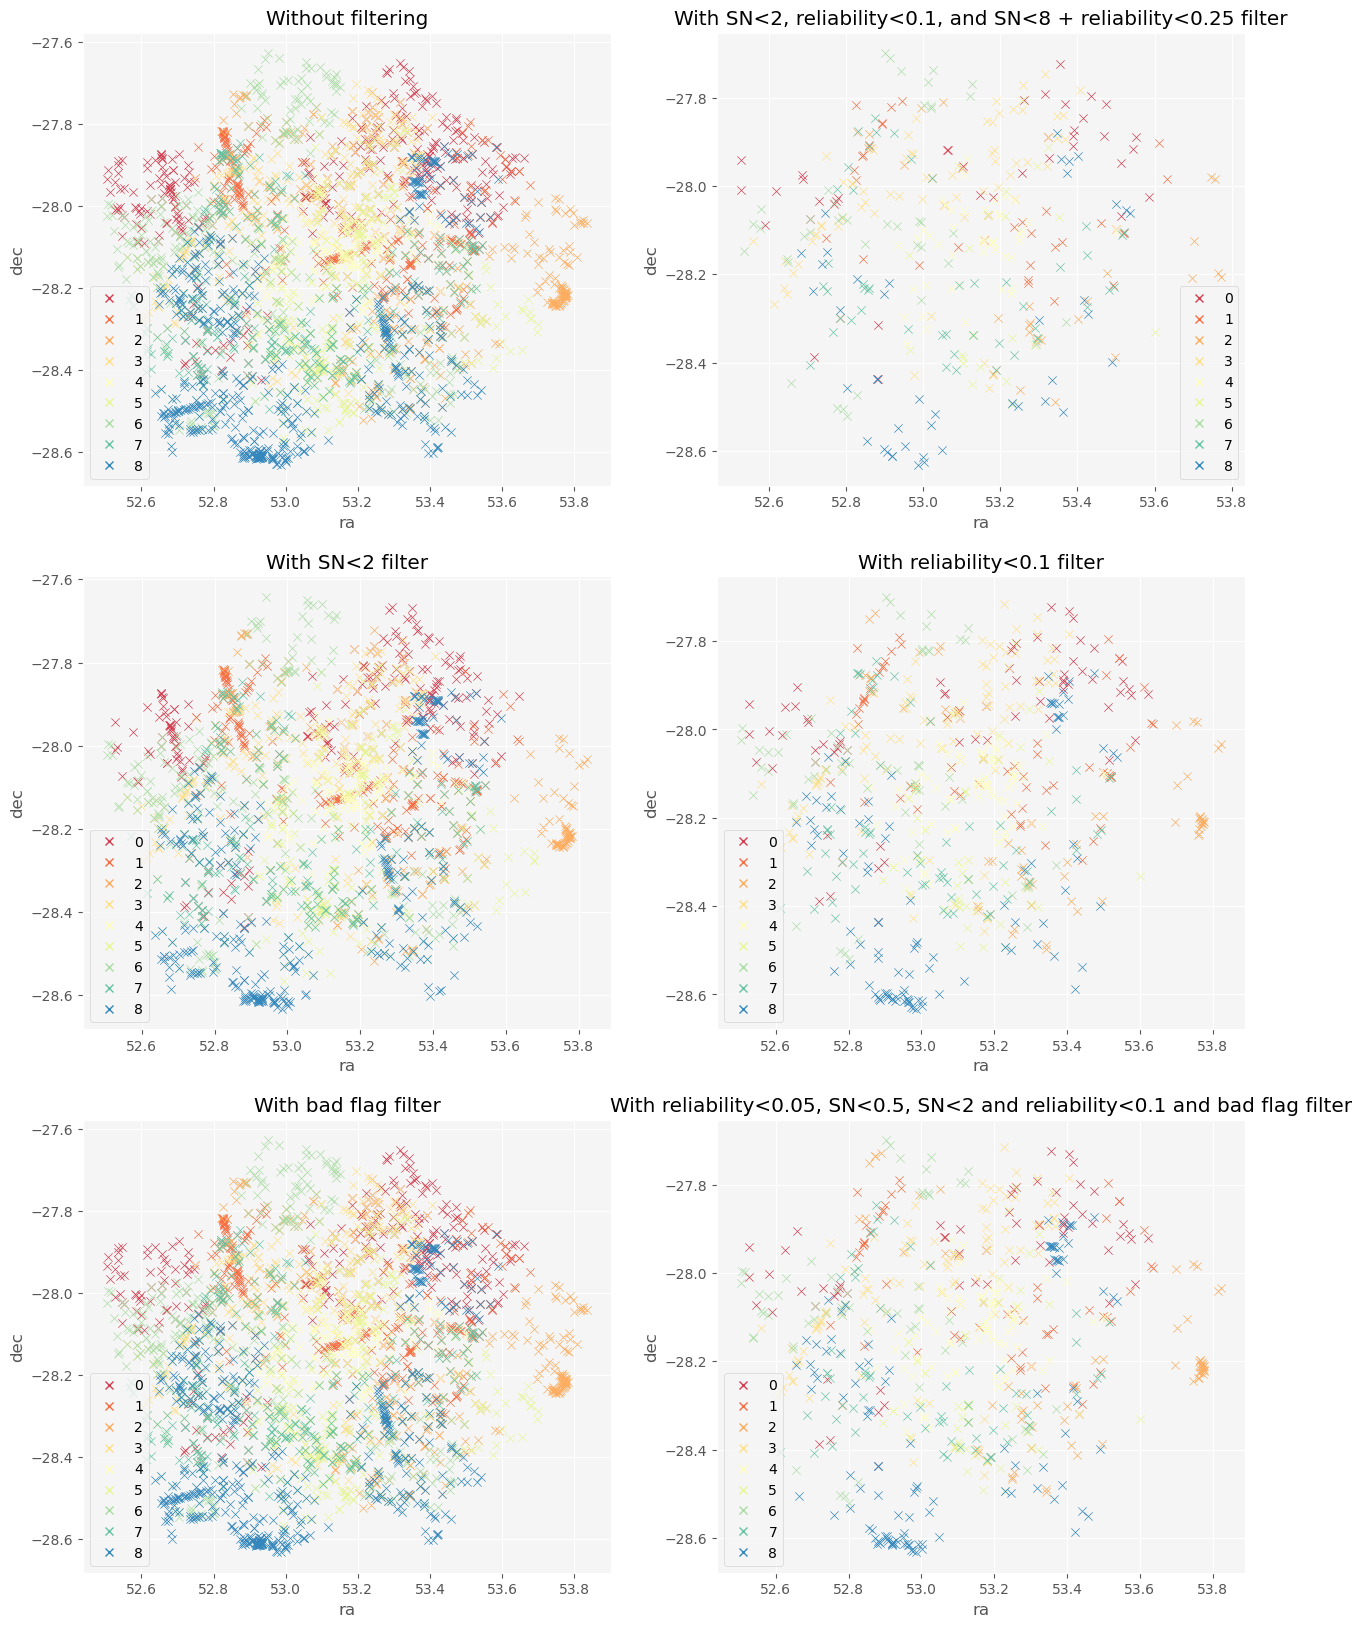

In [36]:
f, axes = plt.subplots(3, 2, figsize=(15, 20))
detectors = list(range(9))

# Set custom legend with all detectors
palette = sns.color_palette("Spectral", 9)
legend_elements = [Line2D([0], [0], marker='x', color=palette[i], linestyle='None', 
                         label=f'{i}') for i in range(9)]
for d in detectors:
    filtered_df = main_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[0, 0], color=palette[d])
    filtered_df = test_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[0, 1], color=palette[d])
    filtered_df = test1_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[1, 0], color=palette[d])
    filtered_df = test2_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[1, 1], color=palette[d])
    filtered_df = test3_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[2, 0], color=palette[d])
    filtered_df = test4_run['rsrcTable'].query('detector == @d')
    ax = sns.scatterplot(data=filtered_df, x='ra', y='dec', 
                         marker='x', alpha=1.0, ax=axes[2, 1], color=palette[d])


axes[0, 0].legend(handles=legend_elements)
axes[0, 0].set(title=main_run['run_name'])                        
axes[0, 1].legend(handles=legend_elements)
axes[0, 1].set(title=test_run['run_name'])                     
axes[1, 0].legend(handles=legend_elements)
axes[1, 0].set(title=test1_run['run_name'])                     
axes[1, 1].legend(handles=legend_elements)
axes[1, 1].set(title=test2_run['run_name'])               
axes[2, 0].legend(handles=legend_elements)
axes[2, 0].set(title=test3_run['run_name'])                     
axes[2, 1].legend(handles=legend_elements)
axes[2, 1].set(title=test4_run['run_name'])

Plotting the diaSources in detector space reveals slightly different clusters of artifacts.
Now streaks and clumps of sources (probably from a bright star) are more apparent.
Note in particular the clump of orange sources on the middle right, the dense group of blue sources in the bottom left, and the multi-color streak in the upper left.
The orange and blue clusters are almost certainly artifacts, and are unfortunately still present (though reduced) in all of the plots.
The multi-color streak in the upper left is interesting.
The other streaks appear to be contained within a single detector, and in the detector-space plots above seem to be vertical columns.
This streak extends across multiple detectors, but also appears within the same detector, which suggests it is a satellite trail that did not get masked.

## 9. Explore flags and cuts on the `main` run
Note that this is not as accurate as including the settings in the actual run

In [37]:
sources_original = main_run['rsrcTable'].copy(deep=True)

In [38]:
def filter_sources(sources_in, reliability=0, snr_threshold=0, snr_multiplier=0, low_SN_reliability=0, badFlags=[]):
    fluxField = "apFlux"
    fluxErrField = "apFluxErr"
    sources = sources_in.copy(deep=True)
    sources = sources.query('reliability > @reliability')
    if len(badFlags) > 0:
        query_str = " and ".join([f"{flag} == False" for flag in badFlags])
        sources = sources.query(query_str)
    
    signalToNoise = np.abs(np.array(sources[fluxField]/sources[fluxErrField]))
    detectionThreshold2 = snr_threshold*snr_multiplier
    snr_flag = signalToNoise < snr_threshold
    lowSnrReliability_flag = ((signalToNoise < detectionThreshold2) & (sources['reliability'] < low_SN_reliability))
    flagged = snr_flag | lowSnrReliability_flag
    goodSources = sources[~flagged]
    return goodSources

In [39]:
sources = filter_sources(sources_original, reliability=0.01, snr_threshold=0.5, snr_multiplier=4, low_SN_reliability=0.1, badFlags=badFlags)

In [40]:
len(sources)

1010

In [41]:
reliability_arr = [0, 0.01, 0.05, 0.1, 0.2, 0.25, 0.333, 0.5]
snr_threshold_arr = [0, 0.1, 0.25, 0.5, 1, 2]
low_SN_reliability = [0, 0.1, 0.2, 0.5, 0.9]

In [42]:

for low_snr_rel in low_SN_reliability:
    results_df = pd.DataFrame(
        index=reliability_arr,
        columns=snr_threshold_arr
    )
    for rel, snr in product(reliability_arr, snr_threshold_arr):
        results_df.loc[rel, snr] = len(filter_sources(sources_original,
                                                      reliability=rel,
                                                      snr_threshold=snr,
                                                      snr_multiplier=4,
                                                      low_SN_reliability=low_snr_rel,
                                                      badFlags=badFlags,
                                                     )
                                      )
    results_df.index.name = 'Reliability'
    results_df.columns.name = 'SNR Threshold'
    print(f"With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<{low_snr_rel}")
    display(results_df)

With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<0


SNR Threshold,0.00,0.10,0.25,0.50,1.00,2.00
Reliability,,,,,,
0.000,3242,3150,3035,2830,2428,1748
0.010,1195,1184,1171,1146,1082,901
0.050,691,685,680,672,647,548
0.100,592,588,583,576,553,467
0.200,477,474,469,463,443,369
0.250,436,433,428,422,403,333
0.333,374,371,366,360,342,275
0.500,189,188,185,181,168,125


With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<0.1


SNR Threshold,0.00,0.10,0.25,0.50,1.00,2.00
Reliability,,,,,,
0.000,3242,2924,2458,1857,1106,588
0.010,1195,1167,1112,1010,773,482
0.050,691,685,677,657,610,471
0.100,592,588,583,576,553,467
0.200,477,474,469,463,443,369
0.250,436,433,428,422,403,333
0.333,374,371,366,360,342,275
0.500,189,188,185,181,168,125


With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<0.2


SNR Threshold,0.00,0.10,0.25,0.50,1.00,2.00
Reliability,,,,,,
0.000,3242,2923,2454,1842,1059,491
0.010,1195,1166,1108,995,726,385
0.050,691,684,673,642,563,374
0.100,592,587,579,561,506,370
0.200,477,474,469,463,443,369
0.250,436,433,428,422,403,333
0.333,374,371,366,360,342,275
0.500,189,188,185,181,168,125


With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<0.5


SNR Threshold,0.00,0.10,0.25,0.50,1.00,2.00
Reliability,,,,,,
0.000,3242,2921,2445,1804,890,265
0.010,1195,1164,1099,957,557,159
0.050,691,682,664,604,394,148
0.100,592,585,570,523,337,144
0.200,477,472,460,425,274,143
0.250,436,431,420,389,251,143
0.333,374,369,359,331,223,141
0.500,189,188,185,181,168,125


With sources below between SNR_threshold < SNR < SNR_threshold*4 cut if they have reliability<0.9


SNR Threshold,0.00,0.10,0.25,0.50,1.00,2.00
Reliability,,,,,,
0.000,3242,2918,2432,1753,771,159
0.010,1195,1161,1086,906,438,53
0.050,691,679,651,553,275,42
0.100,592,582,557,472,218,38
0.200,477,469,447,374,155,37
0.250,436,428,407,338,132,37
0.333,374,366,346,280,104,35
0.500,189,185,172,130,49,19


From the above table, a cut on reliability below 0.1 seems to remove a large fraction of the sources.
With the reliability cut, the cut on signal to noise is not as significant.
I suggest a small threshold that is still above zero, perhaps 0.5.
With those two cuts in place, the low signal to noise reliability cut needs to be at least 0.2 for it to have any effect.